In [1]:
# importing the libraries
import numpy as np


from peakutils.plot import plot as pplot
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
from scipy import interpolate

import pandas as pd

In [18]:
def indexes(y, thres=0.3, min_dist=1):
    """Peak detection routine.

    Finds the numeric index of the peaks in *y* by taking its first order difference. By using
    *thres* and *min_dist* parameters, it is possible to reduce the number of
    detected peaks. *y* must be signed.

    Parameters
    ----------
    y : ndarray (signed)
        1D amplitude data to search for peaks.
    thres : float between [0., 1.]
        Normalized threshold. Only the peaks with amplitude higher than the
        threshold will be detected.
    min_dist : int
        Minimum distance between each detected peak. The peak with the highest
        amplitude is preferred to satisfy this constraint.

    Returns
    -------
    ndarray
        Array containing the numeric indexes of the peaks that were detected
    """
    y_raw = y
    y = [abs(k) for k in y_raw]
    
    if isinstance(y, np.ndarray) and np.issubdtype(y.dtype, np.unsignedinteger):
        raise ValueError("y must be signed")

    thres = thres * (np.max(y) - np.min(y)) + np.min(y)
    min_dist = int(min_dist)

    # compute first order difference
    dy = np.diff(y)

    # propagate left and right values successively to fill all plateau pixels (0-value)
    zeros,=np.where(dy == 0)
    
    # check if the singal is totally flat
    if len(zeros) == len(y) - 1:
        return np.array([])
    
    while len(zeros):
        # add pixels 2 by 2 to propagate left and right value onto the zero-value pixel
        zerosr = np.hstack([dy[1:], 0.])
        zerosl = np.hstack([0., dy[:-1]])

        # replace 0 with right value if non zero
        dy[zeros]=zerosr[zeros]
        zeros,=np.where(dy == 0)

        # replace 0 with left value if non zero
        dy[zeros]=zerosl[zeros]
        zeros,=np.where(dy == 0)

    # find the peaks by using the first order difference
    peaks = np.where((np.hstack([dy, 0.]) < 0.)
                     & (np.hstack([0., dy]) > 0.)
                     & (y > thres))[0]

    # handle multiple peaks, respecting the minimum distance
    if peaks.size > 1 and min_dist > 1:
        highest = peaks[np.argsort(y[peaks])][::-1]
        rem = np.ones(y.size, dtype=bool)
        rem[peaks] = False

        for peak in highest:
            if not rem[peak]:
                sl = slice(max(0, peak - min_dist), peak + min_dist + 1)
                rem[sl] = True
                rem[peak] = False

        peaks = np.arange(y.size)[~rem]

    return peaks

In [6]:
#create wavelength array
nm = np.arange(850, 1600, 1)

In [4]:
def gaussian(nm, a, x0, sigma):
    """
    gaussian function
    """
    gaussian_array = a * np.exp(- ((nm - x0) ** 2.0) / (2 * (sigma ** 2.0))) 
    
    return gaussian_array

In [7]:
#create a third gaussian
a3 = 0.5
x0_3 = 1100
sigma_3 = 60


#generate a gaussian model
species_3 = gaussian(nm, a3, x0_3, sigma_3)

In [8]:
#create a third gaussian
a2 = 0.5
x0_2 = 900
sigma_2 = 10


#generate a gaussian model
species_2 = gaussian(nm, a2, x0_2, sigma_2)

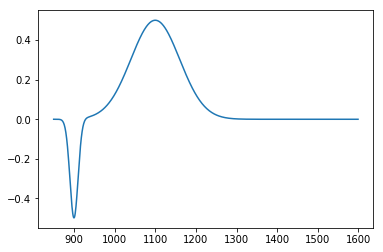

In [15]:
species = species_3 - species_2
plt.figure()
plt.plot(nm, species)

In [22]:
peaks = indexes(species, thres=0.3, min_dist=1)
peaks

array([ 50, 250])

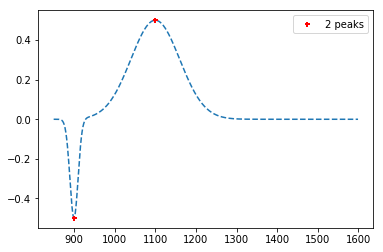

In [20]:
pplot(nm, species, peaks.astype('int64'))